# Ahmed's API Key

In [1]:
SOLD_URL_ENDPOINT = 'https://redfin-com-data.p.rapidapi.com/properties/search-sold'
AUTOCOMPLETE_URL_ENDPOINT = "https://redfin-com-data.p.rapidapi.com/properties/auto-complete"
RAPIDAPI_KEY = 'e30df9c98fmshc8107a744002a40p1825e4jsn566f389d12de'

# Marwa's API Key

In [2]:

headers = {
	"x-rapidapi-key": "d189a8f130msh1de215a13d1f7b0p101758jsnfb514e240299",
	"x-rapidapi-host": "redfin-com-data.p.rapidapi.com"
}


# Salama API Key

In [3]:
headers = {
	"x-rapidapi-key": "c8428f1837msh24e02ec82ded1efp1692e8jsn591739e697c4",
	"x-rapidapi-host": "redfin-com-data.p.rapidapi.com"
}

In [4]:
import requests
import pandas as pd
import logging
import datetime

# Constants and Configurations
RAPIDAPI_KEY = 'e30df9c98fmshc8107a744002a40p1825e4jsn566f389d12de'
API_URL = 'https://redfin-com-data.p.rapidapi.com/properties/search-sold'
CSV_FILE_PATH = 'Data/Export-NH-counties (Cleaned).xlsx - Sheet1.csv'
EXCEL_FOLDER = 'Zillow'
EXCEL_FILE_PREFIX = 'Letters'

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def fetch_data_from_redfin(region_id, lotSize, hoaFees, soldwithin, homeType, limit):
    url = "https://redfin-com-data.p.rapidapi.com/properties/search-sold"

    querystring = {
        "regionId": region_id,
        "lotSize": lotSize,
        "hoaFees": hoaFees,
        "soldWithin": soldwithin,
        "homeType": homeType,
        "limit": limit
    }

    headers = {
	"x-rapidapi-key": "de31f66965msh9e951a09766a622p15d728jsnbc7890b8dc5b",
	"x-rapidapi-host": "redfin-com-data.p.rapidapi.com"
    }

    try:
        response = requests.get(url, headers=headers, params=querystring)
        response.raise_for_status()  # Raise an exception for bad status codes
        data = response.json().get('data', [])
        return data
    except requests.exceptions.RequestException as e:
        logging.error(f"Request failed: {e}")
        return []

def process_property_data(properties, region_id, zipcode):
    processed_data = []

    for property_data in properties:
        home_data = property_data.get("homeData", {})
        price_info = home_data.get("priceInfo", {})
        lot_size_info = home_data.get("lotSize", {})

        price = price_info.get("amount", "Not available")
        lot_size_sqft = lot_size_info.get("amount", "Not available")

        # Convert lot size from sqft to acres if available
        if lot_size_sqft != "Not available":
            try:
                lot_size_acres = float(lot_size_sqft) / 43560.0  # converting from sqft to acres
                lot_size_acres = round(lot_size_acres, 2)  # Round to 2 decimal places
                lot_size_str = lot_size_acres
            except ValueError:
                lot_size_str = "Not available"
        else:
            lot_size_str = "Not available"

        processed_data.append({
            'Price': price,
            'Zipcode': zipcode,
            'Region ID': region_id,
            'Lot Size': lot_size_str
        })

    return pd.DataFrame(processed_data)

def save_data_to_excel(df):
    current_month = datetime.datetime.now().strftime("%B")
    current_year = datetime.date.today().year
    excel_file = f'{EXCEL_FOLDER}/{EXCEL_FILE_PREFIX}_{current_month}_{current_year}.xlsx'
    df.to_excel(excel_file, index=False)
    logging.info(f"All data saved to {excel_file}")

def get_region_id(zipcode):
    url = "https://redfin-com-data.p.rapidapi.com/properties/auto-complete"

    querystring = {"query": zipcode}

    headers = {
	"x-rapidapi-key": "c8428f1837msh24e02ec82ded1efp1692e8jsn591739e697c4",
	"x-rapidapi-host": "redfin-com-data.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)

    data = response.json()

    # Access the id value
    id_value = data['data'][0]['rows'][0]['id']
    return id_value

def load_zipcodes_from_csv(csv_file):
    df = pd.read_csv(csv_file, dtype={'ZIP': str})
    df['ZIP'] = "0" + df['ZIP']
    zipcodes_float_list = df['ZIP'].dropna().unique()
    return zipcodes_float_list

def main():
    zipcodes = load_zipcodes_from_csv(CSV_FILE_PATH)
    lotSize = "43560,174240"
    soldwithin = 365
    homeType = 5
    hoaFees = 0
    limit = 100
    processed_data = pd.DataFrame()
    for zipcode in zipcodes:
        region_id = get_region_id(zipcode)

        properties = fetch_data_from_redfin(region_id, lotSize, hoaFees, soldwithin, homeType, limit)

        if properties:
            processed_data = pd.concat([process_property_data(properties, region_id, zipcode), processed_data], axis=0)

            save_data_to_excel(processed_data)
        else:
            logging.warning(f"No data fetched for zipcode {zipcode}.")

if __name__ == "__main__":
    main()


FileNotFoundError: [Errno 2] No such file or directory: 'Data/Export-NH-counties (Cleaned).xlsx - Sheet1.csv'

In [ ]:
# Function to remove outliers using IQR for each group
def remove_outliers(group):
    Q1 = group['PPA'].quantile(0.25)
    Q3 = group['PPA'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['PPA'] >= lower_bound) & (group['PPA'] <= upper_bound)]

In [ ]:
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

CSV_FILE_PATH = 'Data/Export-NH-counties (Cleaned).xlsx - Sheet1.csv'
EXCEL_FOLDER = '../../../Data/Zillow'
EXCEL_FILE_PREFIX = 'Letters'
current_month = datetime.datetime.now().strftime("%B")
current_year = datetime.date.today().year

# Load data
df = pd.read_excel(f'{EXCEL_FOLDER}/{EXCEL_FILE_PREFIX}_{current_month}_{current_year}.xlsx', dtype={'Zipcode': str})

unavailable_zips = df[(df['Lot Size'] == 'Not available') | (df['Price'] == 'Not available')]['Zipcode'].values.tolist()

# Filter out the ZIP codes
df_cleaned = df[~df['Zipcode'].isin(unavailable_zips)]

# Convert Price and Lot Size columns to float
df_cleaned['Price'] = pd.to_numeric(df_cleaned['Price'], errors='coerce')
df_cleaned['Lot Size'] = pd.to_numeric(df_cleaned['Lot Size'], errors='coerce')

# Calculate Price Per Acre (PPA)
df_cleaned['PPA'] = (df_cleaned['Price'] / df_cleaned['Lot Size']).round(2)
df_cleaned['Offer'] = (df_cleaned['PPA'] * 0.4).round(2)

# Remove outliers for PPA within each zipcode group
df_cleaned = df_cleaned.groupby('Zipcode').apply(remove_outliers).reset_index(drop=True)
poor_est_zips = df_cleaned.groupby('Zipcode')['PPA'].agg('count')[df_cleaned.groupby('Zipcode')['PPA'].agg('count') < 3].sort_values(ascending=False).index.to_list()

needed_zips = poor_est_zips + unavailable_zips

# BoXplot on PPA

Unwanted ZIP codes removed and dataset saved successfully.


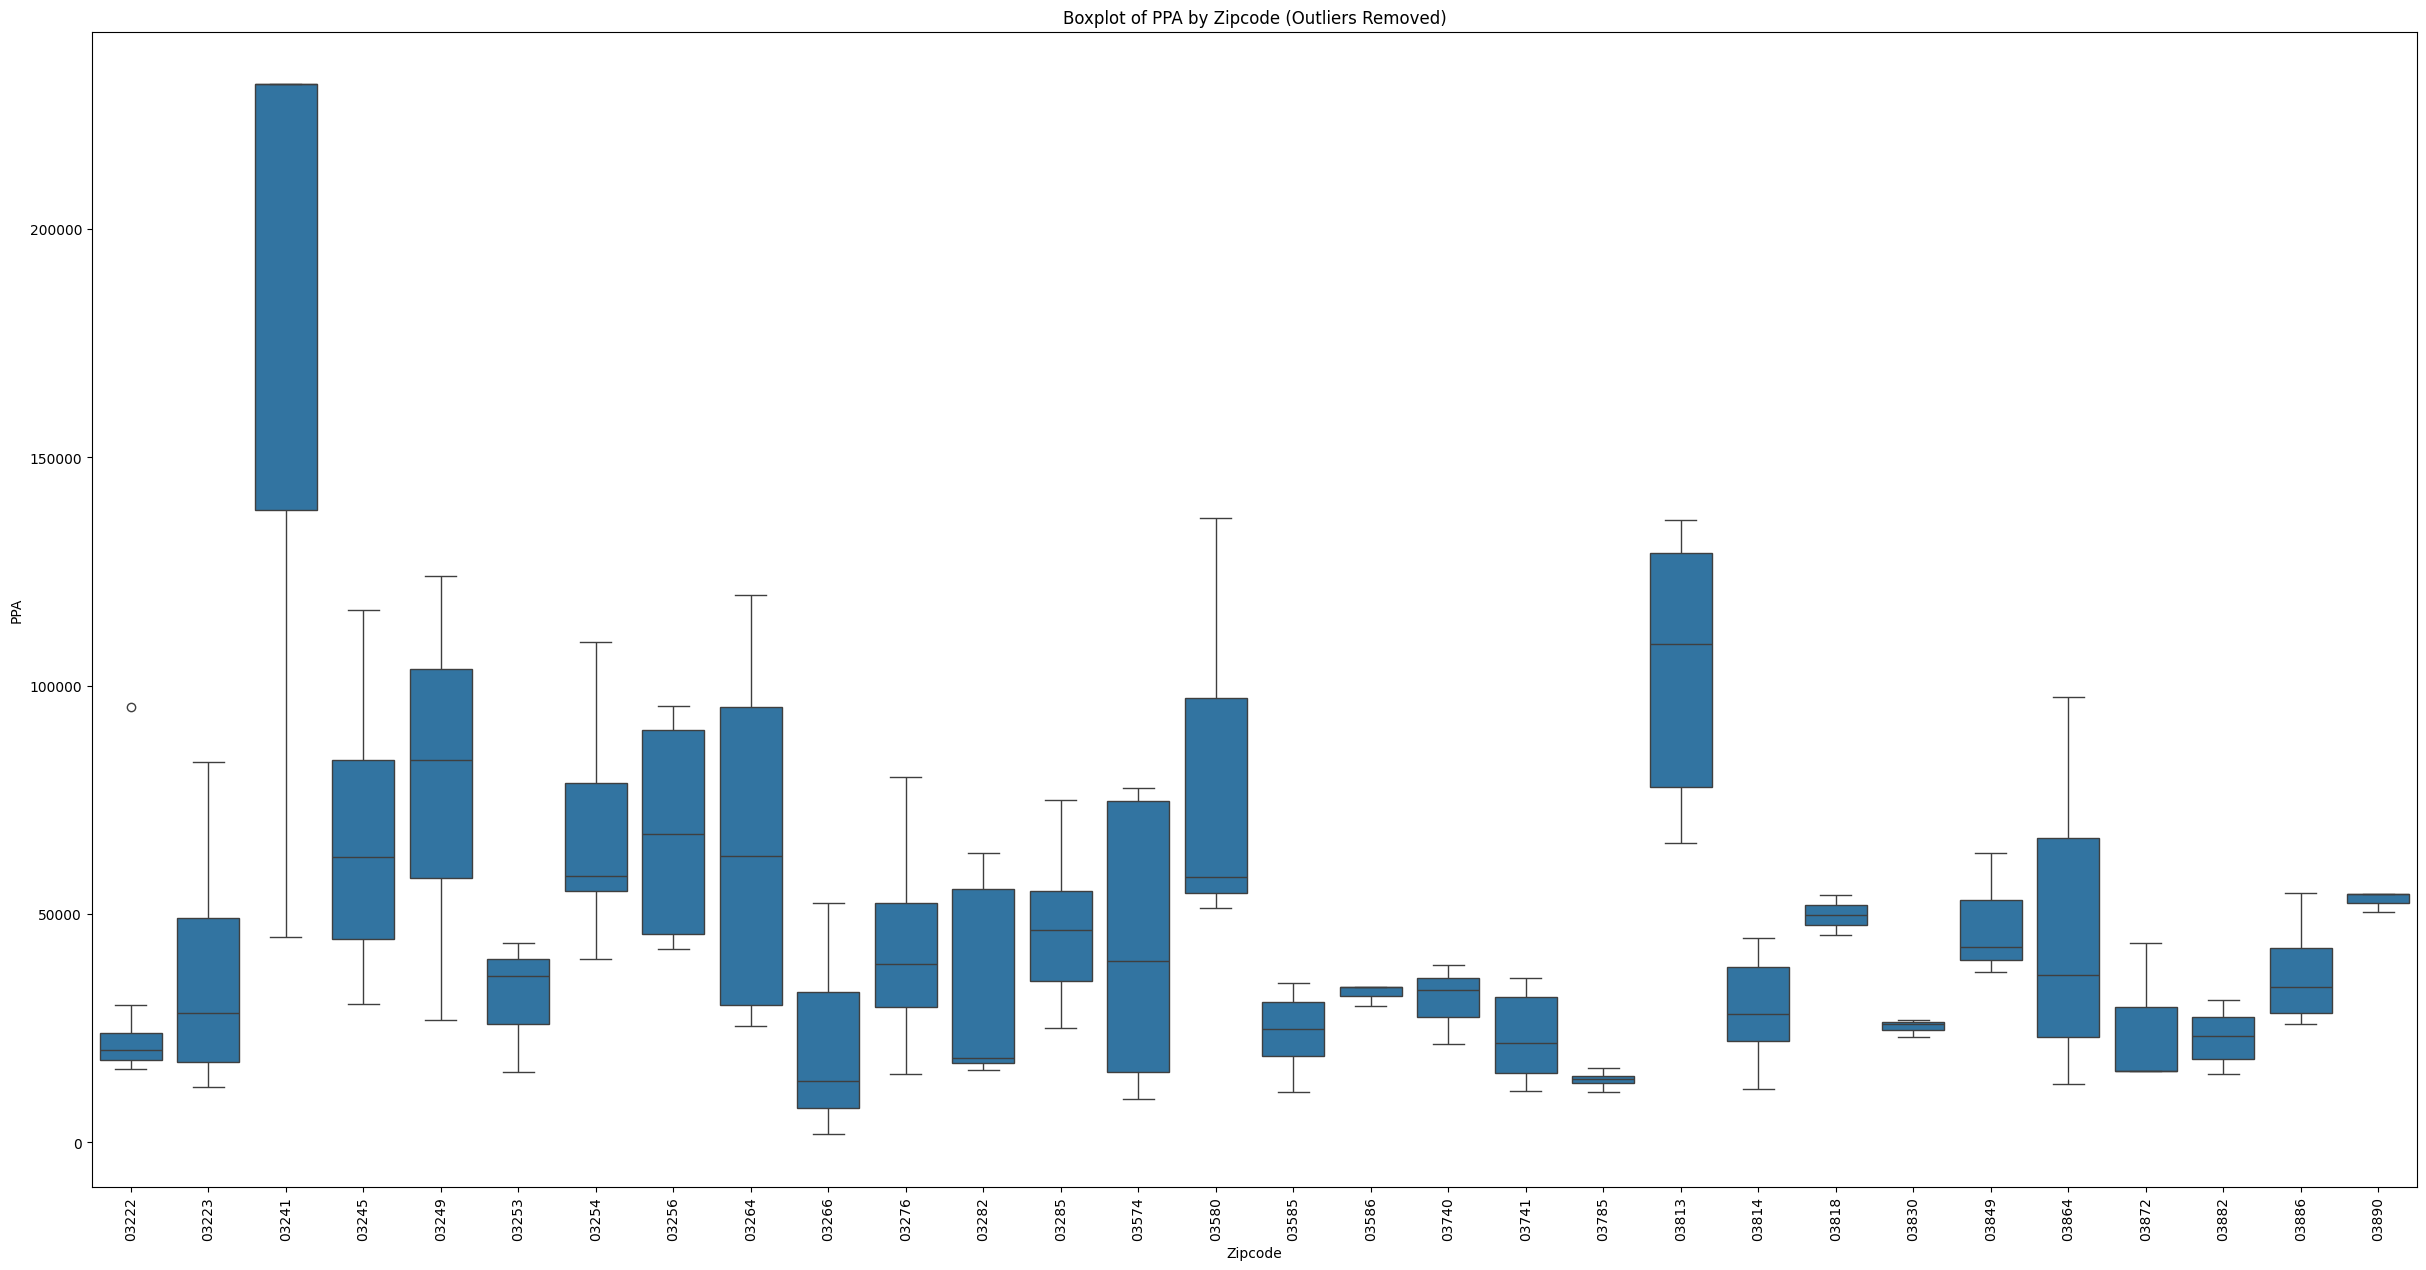

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out the ZIP codes
df_cleaned = df_cleaned[~df_cleaned['Zipcode'].isin(needed_zips)]

# Save the cleaned DataFrame to a new CSV file
round(df_cleaned.groupby('Zipcode')['PPA'].agg('mean')  * 0.4, 2).to_csv('Cleaned Zipcodes.csv')

print("Unwanted ZIP codes removed and dataset saved successfully.")

# Plotting
plt.figure(figsize=(30, 15))
sns.boxplot(x='Zipcode', y='PPA', data=df_cleaned)
plt.xticks(rotation=90)
plt.title('Boxplot of PPA by Zipcode (Outliers Removed)')
plt.savefig('Boxplot on PPAs.png')
plt.show()

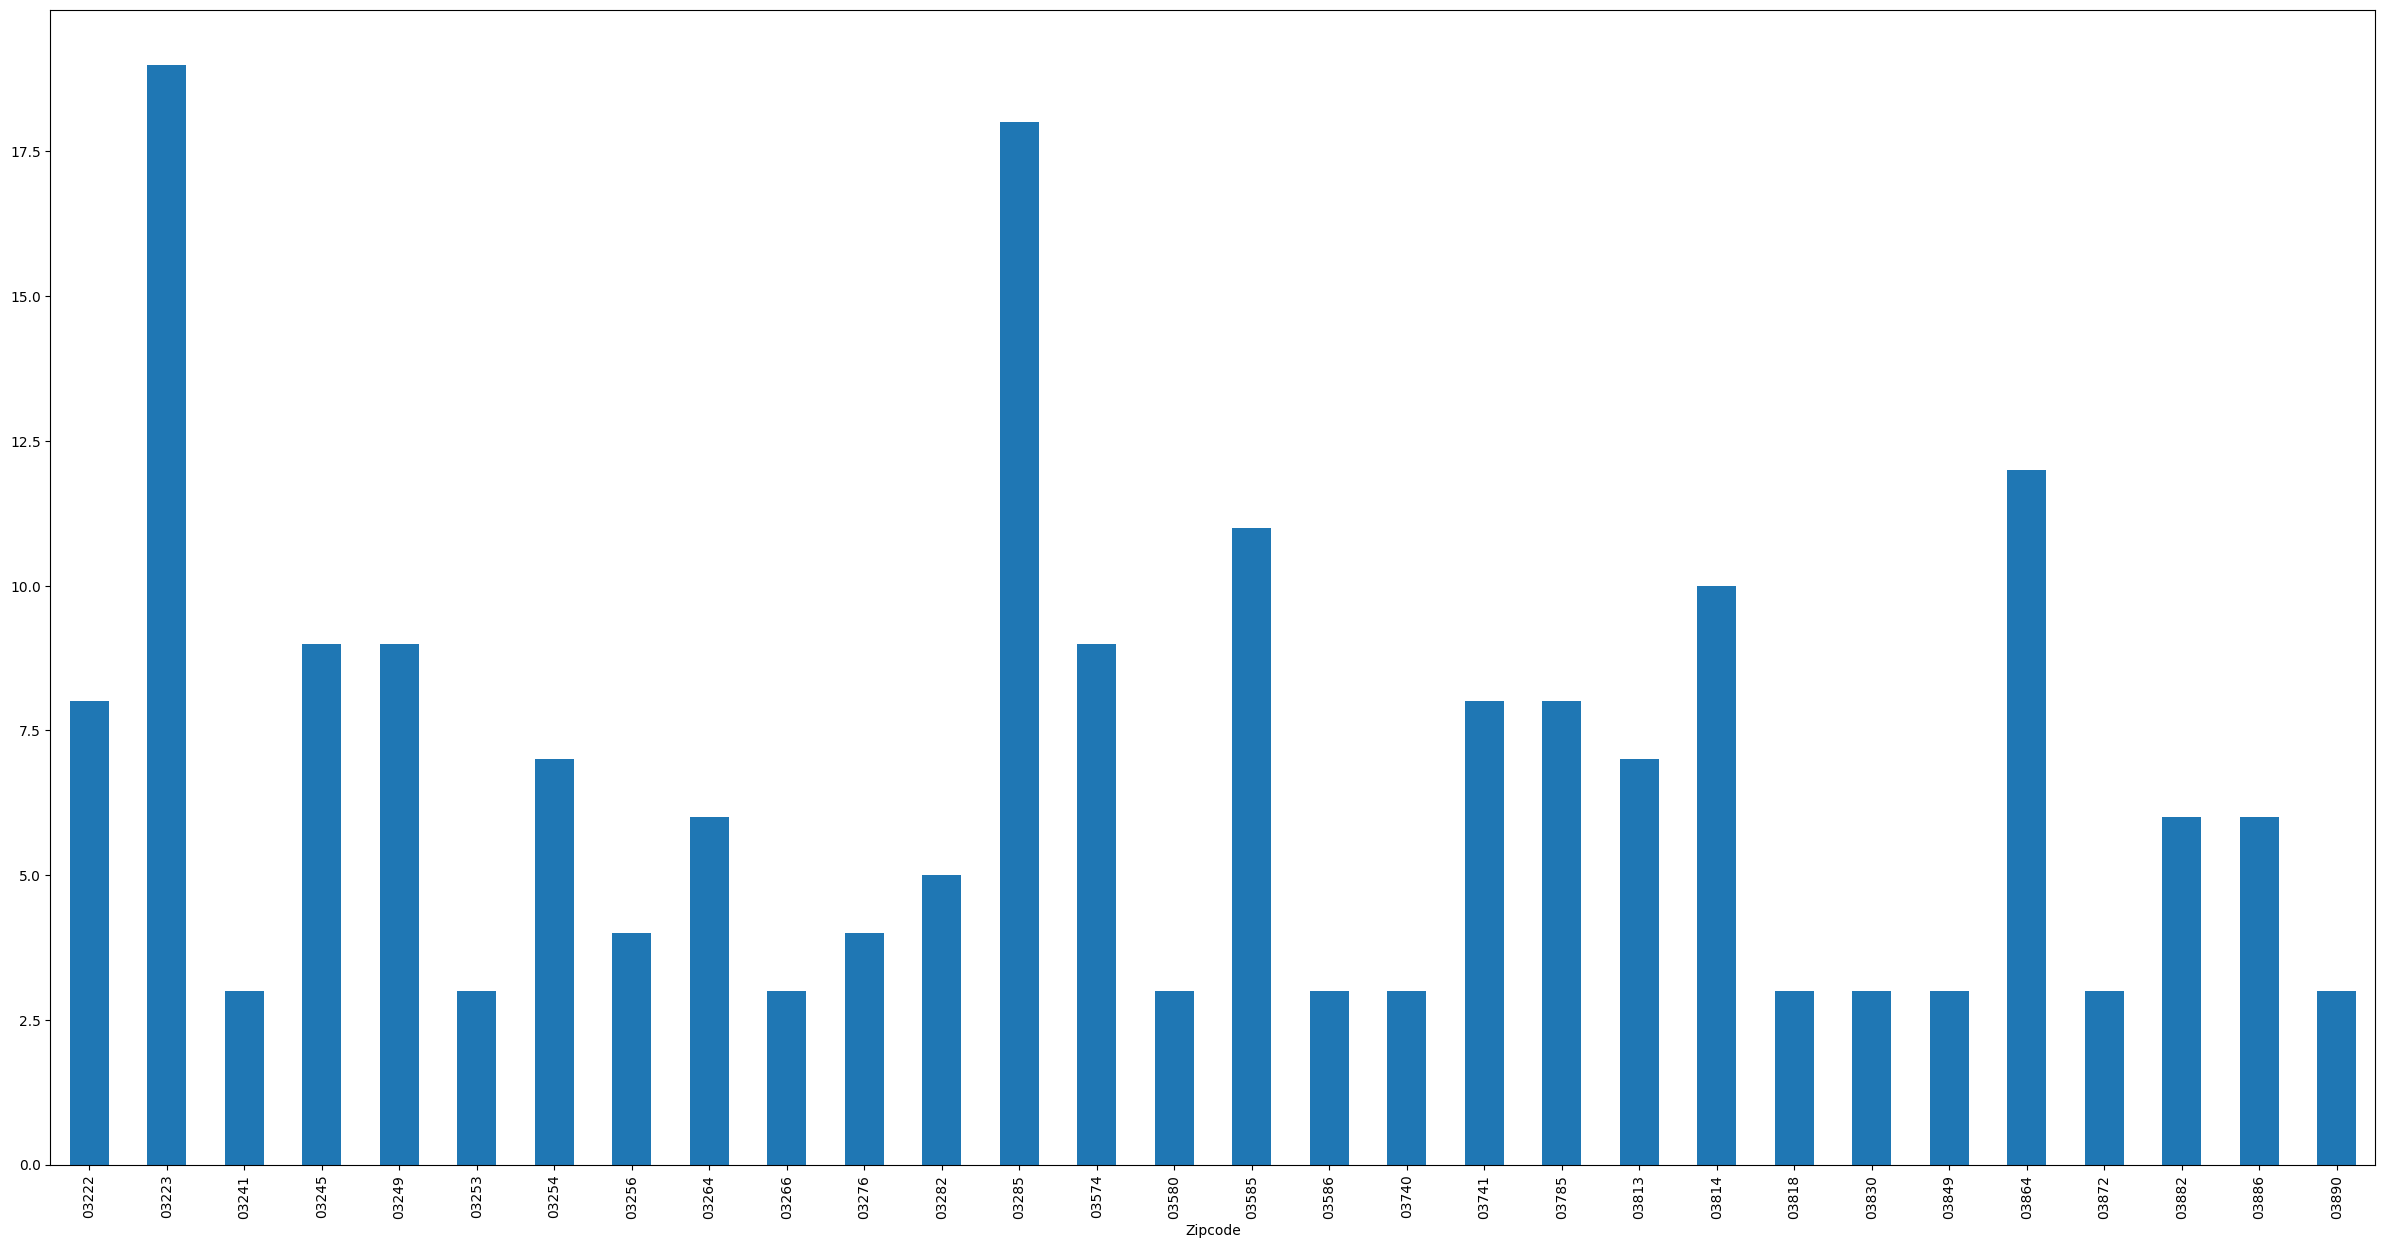

In [ ]:
df_cleaned.groupby('Zipcode')['PPA'].agg('count').plot(kind='bar', figsize=(30 , 15));

# Merge the Cleaned Zipcodes with the Original sheet

In [ ]:
import pandas as pd

# Load the first dataset
df1 = pd.read_csv(CSV_FILE_PATH, dtype={'ZIP': str})

# Load the second dataset containing unique zip codes and average prices
df2 = pd.read_csv('Cleaned Zipcodes.csv', dtype={'ZIP': str})

# Ensure the ZIP columns are of the same type (string is often safest for ZIP codes)
df1['ZIP'] = df1['ZIP'].astype(str)
df2['ZIP'] = df2['ZIP'].astype(str)

# Merge the datasets on the ZIP code
merged_df = pd.merge(df1, df2, on='ZIP', how='left')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('path_to_output_dataset.csv', index=False)

print("Merged dataset saved successfully.")
